# Import Packages

In [1]:
# Version 2.0 : uses waveforms as a function of time ... 
import sys
import os

#PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
#sys.path.append(PATH_with_functions)

import glob
import xarray as xr
import numpy as np
import pandas as pd

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import scipy.interpolate as spi
import scipy.integrate as spint
from scipy.ndimage import gaussian_filter, correlate
from scipy.signal import hilbert,hilbert2,fftconvolve,deconvolve

from functions_cfosat_env import *
from surface_simulation_functions import *
from altimetry_waveforms_functions import *
from matplotlib.dates import DateFormatter
# --- plotting and interactive stuff ----------------------
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator, FixedLocator

#from Envelope_convolution_functions import *

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

cmap0 = 'viridis'

## Define waveforms with wave group effect

Chelton footprint diameter in km: 6.592791788861149
Maximum range used for retracking: 128
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.001000000000000017 160.0
Retracking waveforms 0  out of  1  ------------ 
Retracking result 2D LS: 10.011754465707243 0.004163657459611662 0.00035559971612552336 nan nan
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.0010093930484725137 160.0
Retracking waveforms 0  out of  1  ------------ 
Retracking result 2D LS: 9.531350403458669 0.4204401530848572 0.07752489903463128 nan nan
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.0010093930484725137 160.0
Retracking waveforms 0  out of  1  ------------ 
Retracking result 2D ML: 14.845027971224184 0.7818523445201978 0.4242317285021744 nan nan
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.0010093930484725137 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1

Text(0, 0.5, 'perturbation')

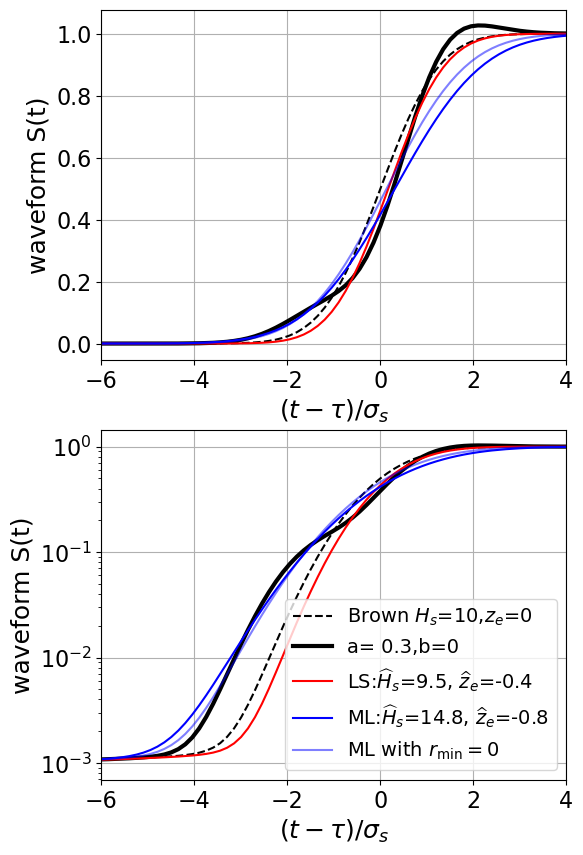

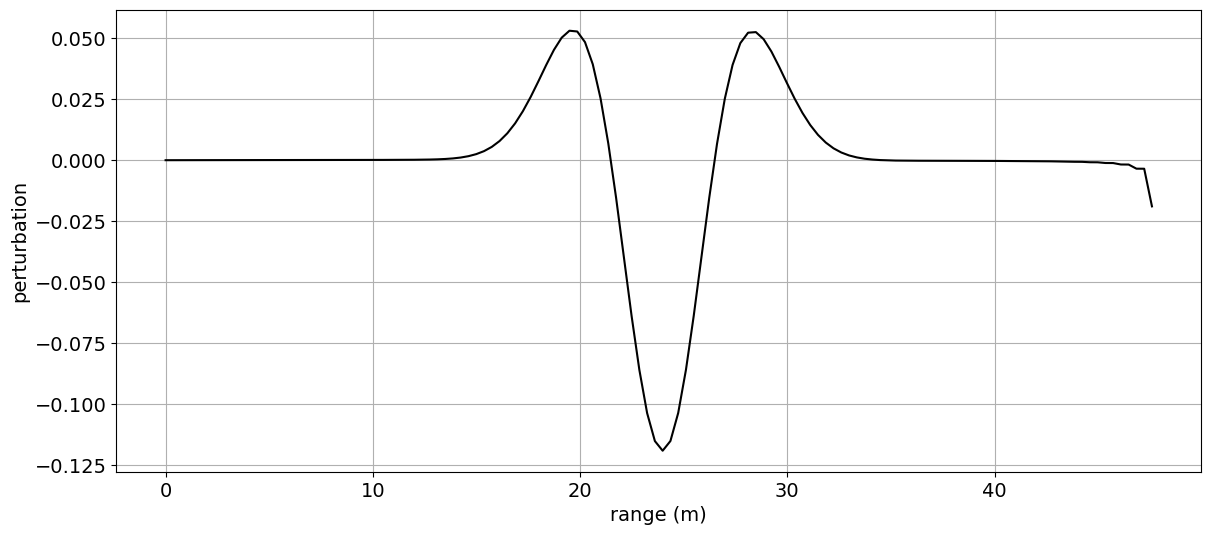

In [2]:
clight = 299792458
Rearth = 6370*1e3

# --- satellite parameters ----------------------------
v_sat = 7*1e3 # satellite velocity in m/s
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.

ialti = 0;

alti_sat = Altis[ialti]
bandwidth = BW[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
bandx     = BX[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
nameSat = namesAltis[ialti]
theta3dB=theta3dBs[ialti];
Gamma = 0.5 * (1.0/np.log(2.0))*np.sin(theta3dB)*np.sin(theta3dB)
#Gamma = 1.
tau=1E9/bandwidth           # time interval in nanoseconds
stonano=1000000000

dr = clight * 1/(2*bandwidth)
nominal_tracking_gate=70

# --- radius to compute waveforms --------------
Hs=10.0
sigs=0.25*Hs*2/clight*stonano
DiamChelton = calc_footprint_diam(Hs,Rorbit = alti_sat) #, pulse_width=1/bandwidth)
radi0=DiamChelton # size of diameter of footprint in pixel
print('Chelton footprint diameter in km:',DiamChelton*0.001)
nominal_tracking_gate=64
min_range_fit=0
range_offset = nominal_tracking_gate*dr  # number of meters above nadir sea level included in waveform
nr=128

ranges = np.arange(0,nr*dr,dr)    # remember to increase 35 to higher values if needed
rlim = np.sqrt((radi0/2)**2+(alti_sat)**2)-alti_sat+range_offset
max_range_fit=128 #np.argmax(ranges[ranges<=rlim])
print('Maximum range used for retracking:',max_range_fit)


wf_model='wf_erf4D'
tax=1E9/bandx

rtot=(2./clight)*stonano  #Converts range to time
times=ranges*rtot
nr2=int(nr/2)
t0=tau*(nr2-1)
PTR=(np.sinc(np.pi*(times-t0)/tax))**2
s=sum(PTR)
PTR=PTR/s

noise=1E-3
wf_fit0=wf_eval(ranges,np.array((0,Hs,1.,0,0.)),clight,'wf_erf2D',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

wf_fita=wf_eval(ranges,np.array((0,Hs,1.,0,0.)),clight,'wf_erf2D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

wf_fit=wf_eval(ranges,np.array((0,Hs,1.,0.3,0.)),clight,'wf_erf4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

wf_lam=wf_eval(ranges,np.array((0,Hs,1.,-1.8,0.)),clight,'wf_erfla',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

ip=0
jp=0
# Select the waveform you want to retrack in the line below (wf_fit ...) 

waveforms=np.expand_dims(np.expand_dims(wf_fit0, 0),0)
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='LS',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)

print('Retracking result 2D LS:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])
wf_fitb=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],1.,0,0.)),clight,'wf_erf2D',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)

waveforms=np.expand_dims(np.expand_dims(wf_fit, 0),0)
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='LS',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)

HsLS=Hs_retrack[ip,jp]
zeLS=-ze_retrack[ip,jp]
print('Retracking result 2D LS:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])
wf_fitb=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],1.,0,0.)),clight,'wf_erf2D',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)


mrat=0.06
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                                    min_gate_rat=mrat,min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)
HsML=Hs_retrack[ip,jp]
zeML=-ze_retrack[ip,jp]
print('Retracking result 2D ML:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])


wf_fitc=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],1.,0,0.)),clight,'wf_erf2D',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)

mrat=0.0
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                                    min_gate_rat=mrat,min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)

wf_fitd=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],1.,0,0.)),clight,'wf_erf2D',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)


mrat=0.06
# check on skewness effect
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erfla',costfun='LS',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)

print('Retracking result  with skewness (LS):',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])

Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    min_method='Nelder-Mead',min_gate_rat=mrat,PTR_model='True',PTR=PTR, wf_model='wf_erfla',costfun='ML',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)

print('Retracking result  with skewness (ML):',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])




fig,axs=plt.subplots(2,1,figsize=(6,10))
ax=axs[0]
timep=(times-nominal_tracking_gate*tau)/sigs
#line1=ax.plot(timep,wf_fit0,color='k',linestyle='dashed',label='Gaussian PTR')
line1=ax.plot(timep,wf_fita,color='k',linestyle='dashed',label=r'Brown $H_s$=10 m, $z_e$=0')
line2=ax.plot(timep,wf_fit,color='k',label='a= 0.3,b=0',linewidth=3)

labLS=r'LS:$\widehat{H}_s$='+f'{HsLS:.1f}'+r', $\widehat{z}_e$='+f'{zeLS:.1f}'
labML=r'ML:$\widehat{H}_s$='+f'{HsML:.1f}'+r', $\widehat{z}_e$='+f'{zeML:.1f}'

line3=ax.plot(timep,wf_fitb,color='r',label=labLS)
line4=ax.plot(timep,wf_fitc,color='b',label=labML)
line5=ax.plot(timep,wf_fitd,color='b',alpha=0.5,label=r'ML with $r_{\mathrm{min}}=0$')
#line4=ax.plot(timep,wf_lam,color='k',alpha=0.5,label='lambda=-3.8')
#line4=ax.plot(timep,wf_fitc,color='b',label='ML fit')

ax.set_xlabel(r'$(t-\tau)/\sigma_s$', fontsize=18)
ax.set_ylabel('waveform S(t)', fontsize=18)
#leg = ax.legend(loc='lower right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
#leg = ax.legend(loc='upper left', fontsize=14)
ax.set_xlim((-6,4))
# Same with log ... 


ax=axs[1]
timep=(times-nominal_tracking_gate*tau)/sigs
#line1=ax.plot(timep,wf_fit0,color='k',linestyle='dashed',label='Gaussian PTR')
line1=ax.plot(timep,wf_fita,color='k',linestyle='dashed',label=r'Brown $H_s$=10,$z_e$=0')
line2=ax.plot(timep,wf_fit,color='k',label='a= 0.3,b=0',linewidth=3)
line3=ax.plot(timep,wf_fitb,color='r',label=labLS)
line4=ax.plot(timep,wf_fitc,color='b',label=labML)
line5=ax.plot(timep,wf_fitd,color='b',alpha=0.5,label=r'ML with $r_{\mathrm{min}}=0$')
#line4=ax.plot(timep,wf_lam,color='k',label='lambda=-3.8')
ax.set_xlabel(r'$(t-\tau)/\sigma_s$', fontsize=18)
ax.set_ylabel('waveform S(t)', fontsize=18)
ax.set_yscale('log')
leg = ax.legend(loc='lower right', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlim((-6,4))
#line3=ax.plot(timep,wf_fitb,color='r',label='LS fit')
leg = ax.legend(loc='lower right', fontsize=14)


fig.savefig('FIG4_erf2D_V2.pdf')

fig,ax=plt.subplots(figsize=(14,6))
line1=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='k',label='erf2D')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='g',label='erf2D')
ax.set_xlabel('range (m)')
ax.set_ylabel('perturbation')




Chelton footprint diameter in km: 6.592791788861149
Maximum range used for retracking: 128
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.0010087637712388423 160.0
Retracking waveforms 0  out of  1  ------------ 
Retracking result 2D LS: 9.999750325286655 2.9247672411304428e-05 3.1670520521182453e-09 nan nan
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.0010089844641447319 160.0
Retracking waveforms 0  out of  1  ------------ 
Retracking result 2D LS: 9.67507356609289 0.44360347612891354 0.07913847452699835 nan nan
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.0010089844641447319 160.0
Retracking waveforms 0  out of  1  ------------ 
Retracking result 2D ML: 15.283188582798383 0.6499388671989489 80.56111982890992 nan nan
size of waveforms array: 1 1 128 alti_sat: 519000.0
Estimated noise level: 0.0010089844641447319 160.0
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 

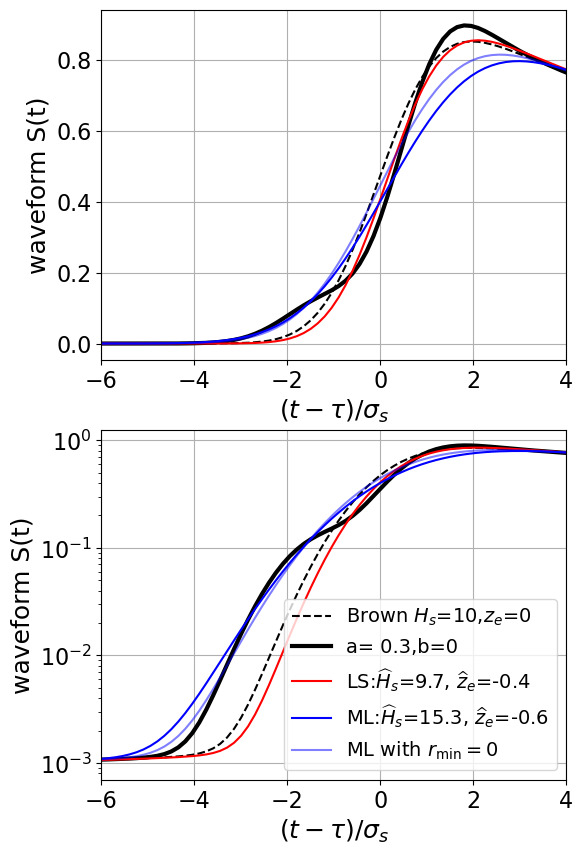

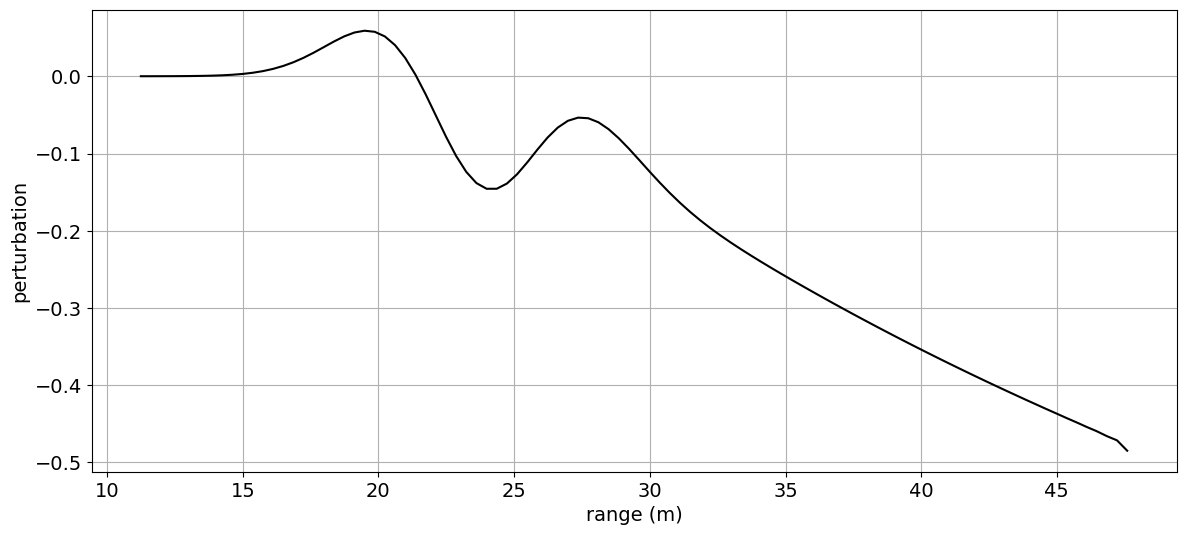

In [3]:
clight = 299792458
Rearth = 6370*1e3

# --- satellite parameters ----------------------------
v_sat = 7*1e3 # satellite velocity in m/s
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.

ialti = 0
theta3dB=theta3dBs[ialti]
Gamma = 0.5 * (1.0/np.log(2.0))*np.sin(theta3dB)*np.sin(theta3dB)
Gamma = 1.

alti_sat = Altis[ialti]
bandwidth = BW[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
bandx     = BX[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
nameSat = namesAltis[ialti]
tau=1E9/bandwidth           # time interval in nanoseconds
stonano=1000000000

dr = clight * 1/(2*bandwidth)
nominal_tracking_gate=70

# --- radius to compute waveforms --------------
Hs=10.0
sigs=0.25*Hs*2/clight*stonano
DiamChelton = calc_footprint_diam(Hs,Rorbit = alti_sat) # pulse_width=1/bandwidth)
radi0=DiamChelton # size of diameter of footprint in pixel
print('Chelton footprint diameter in km:',DiamChelton*0.001)
nominal_tracking_gate=64
min_range_fit=30
range_offset = nominal_tracking_gate*dr  # number of meters above nadir sea level included in waveform
nr=128

ranges = np.arange(0,(nr)*dr,dr)    # remember to increase 35 to higher values if needed
rlim = np.sqrt((radi0/2)**2+(alti_sat)**2)-alti_sat+range_offset
max_range_fit=128 #np.argmax(ranges[ranges<=rlim])
print('Maximum range used for retracking:',max_range_fit)


wf_model='wf_bro4D'
tax=1E9/bandx

rtot=(2./clight)*stonano  #Converts range to time
times=ranges*rtot
nr2=int(nr/2)
t0=tau*(nr2-1)
PTR=(np.sinc(np.pi*(times-t0)/tax))**2
s=sum(PTR)
PTR=PTR/s

noise=1E-3

wf_fita=wf_eval(ranges,np.array((0,Hs,1.,0,0.)),clight,wf_model,PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

wf_fit=wf_eval(ranges,np.array((0,Hs,1.,0.3,0.)),clight,wf_model,PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)




waveforms=np.expand_dims(np.expand_dims(wf_fita, 0),0)
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,theta3dB=theta3dB,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)

print('Retracking result 2D LS:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])
wf_fitb=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],Pu[ip,jp],0,0.)),clight,'wf_brown',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)

waveforms=np.expand_dims(np.expand_dims(wf_fit, 0),0)
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,theta3dB=theta3dB,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)

HsLS=Hs_retrack[ip,jp]
zeLS=-ze_retrack[ip,jp]
print('Retracking result 2D LS:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])
wf_fitb=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],1.,0,0.)),clight,'wf_brown',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)


mrat=0.06
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,theta3dB=theta3dB,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                                    #min_gate_rat=mrat,min_method='pyramid3'   ,PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                                    min_gate_rat=mrat,min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)
HsML=Hs_retrack[ip,jp]
zeML=-ze_retrack[ip,jp]
print('Retracking result 2D ML:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])


wf_fitc=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],1.,0,0.)),clight,'wf_brown',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)

mrat=0.0
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,theta3dB=theta3dB,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                                    min_gate_rat=mrat,min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)

wf_fitd=wf_eval(ranges,np.array((ze_retrack[ip,jp],Hs_retrack[ip,jp],Pu[ip,jp],0,0.)),clight,'wf_brown',noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,PTR=PTR)


mrat=0.03
# check on skewness effect
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,theta3dB=theta3dB,\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brola',costfun='LS',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)

print('Retracking result  with skewness (LS):',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])

Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,theta3dB=theta3dB,\
                                    min_method='Nelder-Mead',min_gate_rat=mrat,PTR_model='True',PTR=PTR, wf_model='wf_brola',costfun='ML',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=0)

print('Retracking result  with skewness (ML):',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])






fig,axs=plt.subplots(2,1,figsize=(6,10))
ax=axs[0]
timep=(times-nominal_tracking_gate*tau)/sigs
#line1=ax.plot(timep,wf_fit0,color='k',linestyle='dashed',label='Gaussian PTR')
line1=ax.plot(timep,wf_fita,color='k',linestyle='dashed',label=r'Brown $H_s$=10 m, $z_e$=0')
line2=ax.plot(timep,wf_fit,color='k',label='a= 0.3,b=0',linewidth=3)

labLS=r'LS:$\widehat{H}_s$='+f'{HsLS:.1f}'+r', $\widehat{z}_e$='+f'{zeLS:.1f}'
labML=r'ML:$\widehat{H}_s$='+f'{HsML:.1f}'+r', $\widehat{z}_e$='+f'{zeML:.1f}'

line3=ax.plot(timep,wf_fitb,color='r',label=labLS)
line4=ax.plot(timep,wf_fitc,color='b',label=labML)
line5=ax.plot(timep,wf_fitd,color='b',alpha=0.5,label=r'ML with $r_{\mathrm{min}}=0$')
#line4=ax.plot(timep,wf_lam,color='k',label='lambda=-3.8')
#line4=ax.plot(timep,wf_fitc,color='b',label='ML fit')

ax.set_xlabel(r'$(t-\tau)/\sigma_s$', fontsize=18)
ax.set_ylabel('waveform S(t)', fontsize=18)
#leg = ax.legend(loc='lower right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
#leg = ax.legend(loc='upper left', fontsize=14)
ax.set_xlim((-6,4))
# Same with log ... 


ax=axs[1]
timep=(times-nominal_tracking_gate*tau)/sigs
#line1=ax.plot(timep,wf_fit0,color='k',linestyle='dashed',label='Gaussian PTR')
line1=ax.plot(timep,wf_fita,color='k',linestyle='dashed',label=r'Brown $H_s$=10,$z_e$=0')
line2=ax.plot(timep,wf_fit,color='k',label='a= 0.3,b=0',linewidth=3)
line3=ax.plot(timep,wf_fitb,color='r',label=labLS)
line4=ax.plot(timep,wf_fitc,color='b',label=labML)
line5=ax.plot(timep,wf_fitd,color='b',alpha=0.5,label=r'ML with $r_{\mathrm{min}}=0$')
#line4=ax.plot(timep,wf_lam,color='k',label='lambda=-3.8')
ax.set_xlabel(r'$(t-\tau)/\sigma_s$', fontsize=18)
ax.set_ylabel('waveform S(t)', fontsize=18)
ax.set_yscale('log')
leg = ax.legend(loc='lower right', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlim((-6,4))
#line3=ax.plot(timep,wf_fitb,color='r',label='LS fit')
leg = ax.legend(loc='lower right', fontsize=14)


fig.savefig('FIG4_bro4D.pdf')

fig,ax=plt.subplots(figsize=(14,6))
line1=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='k',label='erf2D')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='erf2D')
ax.set_xlabel('range (m)')
ax.set_ylabel('perturbation')

waveforms=np.expand_dims(np.expand_dims(wf_fit, 0),0)
Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='Gauss',PTR=([1]), wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)

ip=0
jp=0
print('Retracking result 4D:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])

#waveforms=np.expand_dims(np.expand_dims(wf_fit2, 0),0)
#Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
#                                    min_method='Nelder-Mead',wf_model=wf_model,costfun='LS',mispointing=[0.],\
#                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)

ip=0
jp=0
print('Retracking result:',Hs_retrack[ip,jp],ze_retrack[ip,jp],di_retrack[ip,jp],dar[ip,jp],R0r[ip,jp])


In [4]:

nc2=int((max_range_fit-min_range_fit+1)/2)
tc=tau*(nc2-1)

PTC=(np.sinc(np.pi*(times[0:max_range_fit-min_range_fit]-tc)/tax))**2
s=sum(PTC)
PTC=PTC/s

wf0_c=fftconvolve(wf_fit0,PTR,mode='same')
wf0_d=fftconvolve(wf_fit0[min_range_fit:max_range_fit],PTC,mode='same')
wf0_e=fftconvolve(wf_fit0[min_range_fit:max_range_fit],PTR,mode='same')
#recovered, remainder = deconvolve(wf0_c, PTR)
print('tau:',max_range_fit-min_range_fit+1,nc2,tc,tau,tax,sum(PTC),np.shape(PTC))


tau: 99 49 120.0 2.5 3.125 1.0000000000000009 (98,)


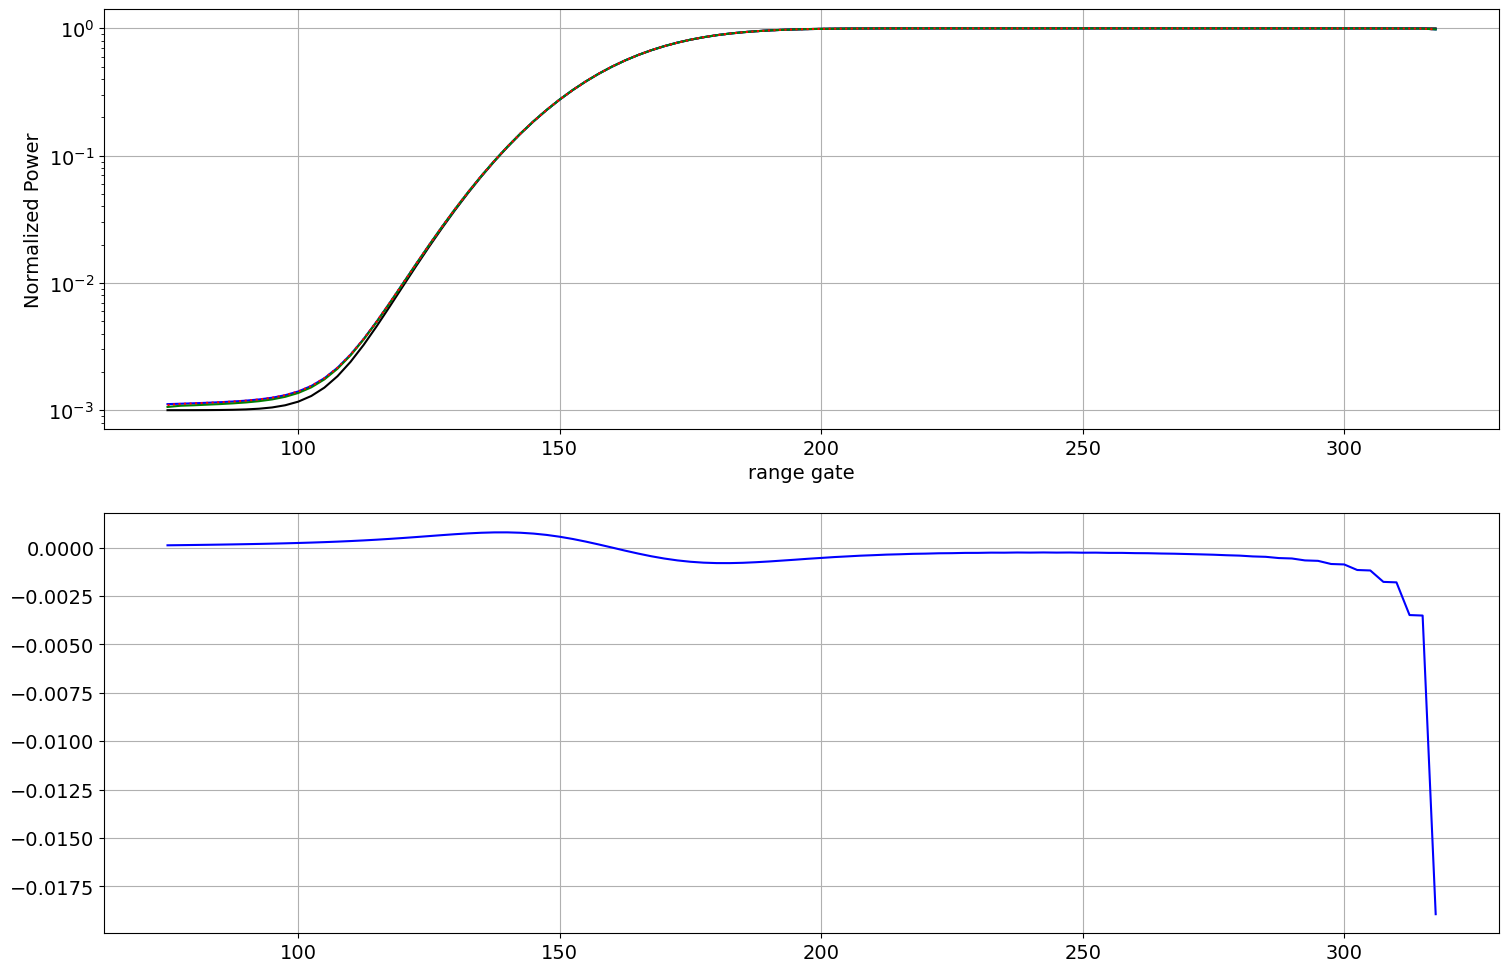

In [5]:
fig,axs=  plt.subplots(2,1,figsize=(18,12))
ax = axs[0]
line1=ax.plot(times[min_range_fit:max_range_fit],wf_fit0[min_range_fit:max_range_fit],color='k',label='erf2D')
line2=ax.plot(times[min_range_fit:max_range_fit],wf0_c[min_range_fit:max_range_fit],color='b',label='PTR')
line3=ax.plot(times[min_range_fit:max_range_fit],wf0_d,color='g',label='PTR')
line3=ax.plot(times[min_range_fit:max_range_fit],wf0_e,color='r',label='PTR',linestyle='dotted')
#line4=ax.plot(times,PTR,color='r',label='PTR')
#line4=ax.plot(times[min_range_fit:max_range_fit],PTC,color='c',label='PTC')
ax.set_yscale('log')

ax.set_xlabel('range gate')
ax.set_ylabel('Normalized Power')

ax = axs[1]
line2=ax.plot(times[min_range_fit:max_range_fit],wf0_c[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='PTR')


In [6]:
# checking on effects of a and b systematically ...

In [7]:
clight = 299792458
Rearth = 6370*1e3
print(np.shape(waveforms) )
# --- satellite parameters ----------------------------
v_sat = 7*1e3 # satellite velocity in m/s
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.

ialti = 0;

alti_sat = Altis[ialti]
bandwidth = BW[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
bandx     = BX[ialti]       # bandwidth in Hz (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
nameSat = namesAltis[ialti]
theta3dB=theta3dBs[ialti];
Gamma = 0.5 * (1.0/np.log(2.0))*np.sin(theta3dB)*np.sin(theta3dB)
#Gamma = 1.
tau=1E9/bandwidth           # time interval in nanoseconds
stonano=1000000000
dr = clight * 1/(2*bandwidth)
nr=128
ranges = np.arange(0,(nr)*dr,dr)   

nominal_tracking_gate=70
Hs=10.0

na=21;nb=41;
atab=np.linspace(-0.3,0.3,na);
btab=np.linspace(0,1,nb);
bigatab=np.zeros((na,nb));
waveforms=np.zeros((na,nb,nr))
for inda in range(na):
    for indb in range(nb): 
        
#        wf_fit=wf_eval(ranges,np.array((0,Hs,1.,0.3,0.)),clight,'wf_erf4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
#                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)

        wf_fit=wf_eval(ranges,np.array((0,Hs,1.,atab[inda],btab[indb])),clight,'wf_erf4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB)
        waveforms[inda,indb,:]=wf_fit

Hs_retrack,ze_retrack,Pu,dar,R0r,di_retrack=retrack_waveforms(waveforms,ranges,max_range_fit,clight,tau=tau,\
                                    #min_method='gridsearch',wf_model=wf_model,costfun='LS',\
                                    #min_method='pyramid4',wf_model=wf_model,costfun='LS',mispointing=[0.],\
                                    #min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='LS',mispointing=[0.],\
                                    min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                                    alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=10)



(1, 1, 128)
size of waveforms array: 21 41 128 alti_sat: 519000.0
Estimated noise level: 0.0010012501877803691 175.0
Retracking waveforms 0  out of  21  ------------ 
Retracking waveforms 1  out of  21  ------------ 
Retracking waveforms 2  out of  21  ------------ 
Retracking waveforms 3  out of  21  ------------ 
Retracking waveforms 4  out of  21  ------------ 
Retracking waveforms 5  out of  21  ------------ 
Retracking waveforms 6  out of  21  ------------ 
Retracking waveforms 7  out of  21  ------------ 
Retracking waveforms 8  out of  21  ------------ 
Retracking waveforms 9  out of  21  ------------ 
Retracking waveforms 10  out of  21  ------------ 
Retracking waveforms 11  out of  21  ------------ 
Retracking waveforms 12  out of  21  ------------ 
Retracking waveforms 13  out of  21  ------------ 
Retracking waveforms 14  out of  21  ------------ 
Retracking waveforms 15  out of  21  ------------ 
Retracking waveforms 16  out of  21  ------------ 
Retracking waveforms 17  o

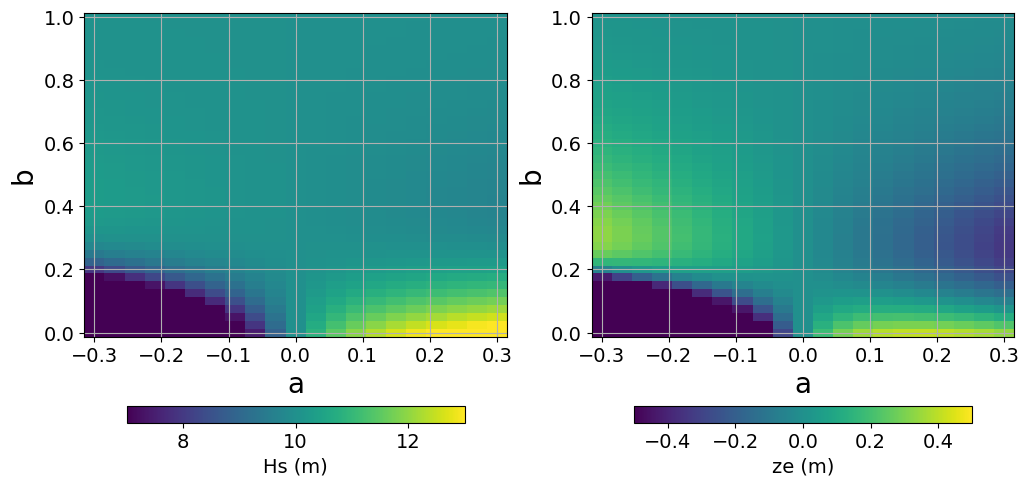

In [11]:
fshrink=0.8
fig,ax=plt.subplots(1,2,figsize=(12,6))
im=ax[0].pcolormesh(atab,btab,Hs_retrack.T,vmin = 7, vmax =13); # ,vmin=Hmin, vmax=Hmax, rasterized=True)
#ax.set_title('$H_s$ [m]')
_= plt.colorbar(im, ax=ax[0],label='Hs (m)', location='bottom',shrink=fshrink)

ax[0].set_xlabel('a', fontsize=20)
ax[0].set_ylabel('b' , fontsize=20)

im=ax[1].pcolormesh(atab,btab,ze_retrack.T,vmin = -0.5, vmax =0.5); # ,vmin=Hmin, vmax=Hmax, rasterized=True)
#ax.set_title('$H_s$ [m]')
_= plt.colorbar(im, ax=ax[1],label='ze (m)', location='bottom',shrink=fshrink)
ax[1].set_xlabel('a', fontsize=20)
ax[1].set_ylabel('b' , fontsize=20)
#fig.savefig('LS_table_impact_ab.pdf')
fig.savefig('ML_table_impact_ab.pdf')